In [5]:
import sys
# CausalML is not supported for Pyhon 2.7
if sys.version_info < (3, 0):
    exit(0)

# Uplift random forest modeling - H2O-3 vs. CausalML

In [2]:
from causalml.inference.tree import UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_plot
from causalml.metrics import plot_gain, plot_qini, plot_lift
from causalml.metrics import auuc_score

import h2o
from h2o.estimators.uplift_random_forest import H2OUpliftRandomForestEstimator

import pandas as pd
from IPython.display import Image

In [3]:
control_name = "control"
treatment_column = "treatment"
response_column = "outcome"
feature_cols = ["feature_"+str(x) for x in range(1,13)]

train_df = pd.read_csv("../../smalldata/uplift/upliftml_train.csv")
test_df = pd.read_csv("../../smalldata/uplift/upliftml_test.csv")

train_df[treatment_column].replace({1: "treatment", 0: "control"}, inplace=True)
test_df[treatment_column].replace({1: "treatment", 0: "control"}, inplace=True)
train_df.shape, test_df.shape

((4989, 17), (5011, 17))

In [4]:
ntree = 40
max_depth = 10
metric_cml="EU"
metric_h2o="Euclidean"

# CausalML

In [5]:
# Train CausalML uplift tree
causalml_uplift_model = UpliftRandomForestClassifier(
        n_estimators=ntree,
        max_depth=max_depth,
        evaluationFunction=metric_cml,
        control_name=control_name,
        min_samples_leaf=10,
        min_samples_treatment=0,
        normalization=False,
        random_state=42)

causalml_uplift_model.fit(train_df[feature_cols].values,
                 treatment=train_df[treatment_column].values,
                 y=train_df[response_column].values)

#test_df = train_df
causalml_preds = causalml_uplift_model.predict(test_df.values)

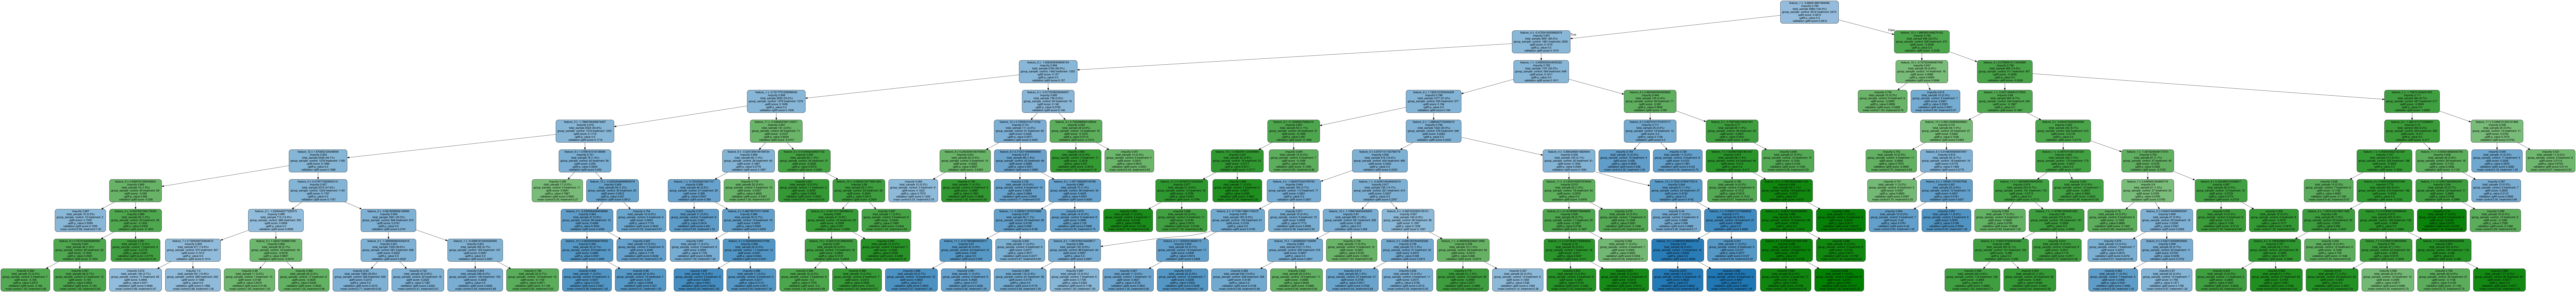

In [6]:
# Plot uplift tree
graph = uplift_tree_plot(causalml_uplift_model.uplift_forest[2].fitted_uplift_tree, feature_cols)
Image(graph.create_png())

# H2O-3

In [7]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  -----------------------------
H2O_cluster_uptime:         2 hours 2 mins
H2O_cluster_timezone:       Europe/Berlin
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.35.0.99999
H2O_cluster_version_age:    2 hours and 29 minutes
H2O_cluster_name:           mori
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4.800 Gb
H2O_cluster_total_cores:    8
H2O_cluster_allowed_cores:  8
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://localhost:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Algos, Core V3, Core V4
Python_version:             3.7.3 candidate
--------------------------  -----------------------------

In [8]:
train_h2o = h2o.H2OFrame(train_df)
train_h2o[treatment_column] = train_h2o[treatment_column].asfactor()
train_h2o[response_column] = train_h2o[response_column].asfactor()
h2o_uplift_model = H2OUpliftRandomForestEstimator(
            ntrees=ntree,
            max_depth=max_depth-1,
            treatment_column=treatment_column,
            uplift_metric=metric_h2o,
            gainslift_bins=10,
            min_rows=10,
            nbins=1000,
            seed=42,
            sample_rate=0.50,
            auuc_type="gain",
            score_each_iteration=False)
h2o_uplift_model.train(y=response_column, x=feature_cols, training_frame=train_h2o)
h2o_uplift_model

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf Model Build progress: |████████████████████████████████████████████████| (done) 100%
Model Details
H2OUpliftRandomForestEstimator :  Uplift Distributed Random Forest
Model Key:  UpliftDRF_model_python_1635850177777_247


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               40.0                      80.0              22667.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        9.0        9.0         9.0        10.0        30.0        18.05



ModelMetricsBinomialUplift: upliftdrf
** Reported on train data. **

AUUC: 400.8819346066166

Scoring History: 


timestamp    duration  number_of_trees  training_auuc
0     2021-11-02 13:52:03   0.003 sec              0.0            NaN
1     2021-11-02 13:52:03   0.105 sec              1.0       0.000000
2     2021-11-02 13:52:03   0.123 sec              2.0     279.049069
3     2021-11-02 13:52:03   0.234 sec              3.0     351.641513
4     2021-11-02 13:52:03   0.329 sec              4.0     360.049022
5     2021-11-02 13:52:04   0.443 sec              5.0     356.105327
6     2021-11-02 13:52:04   0.572 sec              6.0     364.175018
7     2021-11-02 13:52:04   0.689 sec              7.0     362.620589
8     2021-11-02 13:52:04   0.806 sec              8.0     372.312011
9     2021-11-02 13:52:04   0.940 sec              9.0     371.828946
10    2021-11-02 13:52:04   1.068 sec             10.0     367.872765
11    2021-11-02 13:52:04   1.191 sec             11.0     377.018519
12    2021-11-02 13:52:04   1.310 sec             12.0     387.528778
13    2021-11-02 13:52:05   1.437 sec             13.0     399.077660
14    2021-11-02 13:52:05   1.559 sec             14.0     401.258395
15    2021-11-02 13:52:05   1.687 sec             15.0     403.136068
16    2021-11-02 13:52:05   1.806 sec             16.0     399.943314
17    2021-11-02 13:52:05   1.926 sec             17.0     398.918803
18    2021-11-02 13:52:05   2.052 sec             18.0     400.867866
19    2021-11-02 13:52:05   2.179 sec             19.0     400.407466


See the whole table with table.as_data_frame()


In [9]:
test_h2o = h2o.H2OFrame(test_df)
test_h2o[treatment_column] = test_h2o[treatment_column].asfactor()
test_h2o[response_column] = test_h2o[response_column].asfactor()
preds_h2o = h2o_uplift_model.predict(test_h2o)

perf_h2o = h2o_uplift_model.model_performance(test_h2o)
auuc_h2o = perf_h2o.auuc()
print("H2O training metrics AUUC Gain: "+str(auuc_h2o))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
upliftdrf prediction progress: |█████████████████████████████████████████████████| (done) 100%
H2O training metrics AUUC Gain: 413.0785009769531


In [10]:
preds_comp = preds_h2o["uplift_predict"]
preds_comp.names = ["h2o"]
preds_comp["causal"] = h2o.H2OFrame(causalml_preds)
preds_comp["diff"] = abs(preds_comp["h2o"] - preds_comp["causal"])
preds_comp[treatment_column] = h2o.H2OFrame(test_df[treatment_column].values)
preds_comp[response_column] = h2o.H2OFrame(test_df[response_column].values)
preds_comp.summary()
    
min_diff = preds_comp["diff"].min()
max_diff = preds_comp["diff"].max()
mean_diff = preds_comp["diff"].mean(return_frame=False)[0]
print("min: %f max: %f mean: %f" % (min_diff, max_diff, mean_diff))

results = preds_comp.as_data_frame()
results = results[["h2o", "causal", response_column, treatment_column]]
mapping = {'control': 0, 'treatment': 1}
results = results.replace({treatment_column: mapping})


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


h2o causal diff treatment outcome 
 
 
 type real real real enum int 
 mins -0.6264740526676178 -0.4079528250000004 0.01829230800728837 0.0 
 mean 0.08160152274589659 -0.30122345453125104 0.3969286590856897 0.7579325483935342 
 maxs 0.4469720799475908 -0.01810395000000009 0.7552401056061508 1.0 
 sigma 0.1289023084090676 0.05469993310237442 0.08267326615944293 0.4283776621130897 
 zeros 0 0 0 1213 
 missing 0 211 211 0 0 
 0 -0.041345784440636635 -0.3299827000000003 0.28863691555936366 treatment 0.0 
 1 0.03545406088232994 -0.30664637500000036 0.3421004358823303 treatment 1.0 
 2 0.09025202393531806 -0.39024157500000034 0.4804935989353184 control 0.0 
 3 0.08830580376088626 -0.27538890000000027 0.36369470376088653 control 1.0 
 4 0.08333902284502981 -0.30667900000000026 0.39001802284503007 treatment 0.0 
 5 -0.0022025305777787496 -0.1801294250000003 0.17792689442222154 control 1.0 
 6 0.0757184848189354 -0.31974800000000003 0.3954664848189354 control 1.0 
 7 0.13533128127455707 nan nan control 1.0 
 8 0.09469123035669325 -0.3332335000000003 0.42792473035669354 control 0.0 
 9 -0.03024397343397145 -0.3023451250000002 0.27210115156602876 treatment 1.0

min: nan max: nan mean: 0.396929


In [11]:
auuc = auuc_score(results, outcome_col=response_column, treatment_col=treatment_column, normalize=False)
print("H2O AUUC:")
print(auuc["h2o"])
print("CauslML AUUC:")
print(auuc["causal"])
print("Random AUUC:")
print(auuc["Random"])

H2O AUUC:
411.317388736069
CauslML AUUC:
229.61907774479621
Random AUUC:
234.98047847365325


## Qini

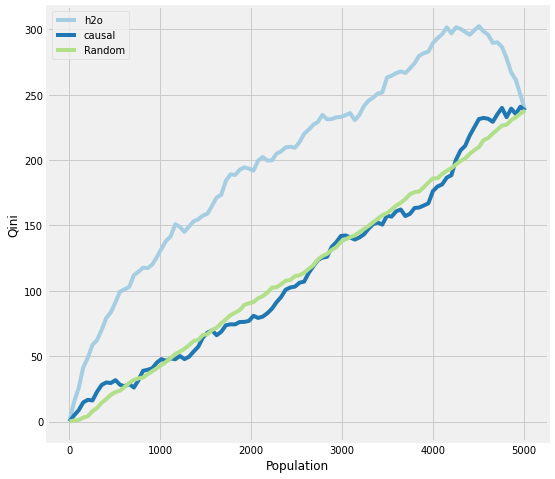

In [12]:
plot_qini(results, outcome_col=response_column, treatment_col=treatment_column)

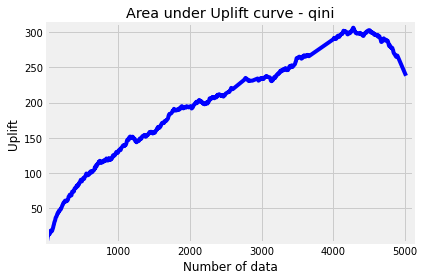

819
[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 122, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 502, 507, 512, 517, 522, 529, 532, 537, 542, 547, 552, 558, 562, 567, 572, 577, 582, 587, 592, 597, 602, 607, 612, 617, 622, 627, 632, 637, 642, 647, 652, 657, 662, 667, 672, 677, 682, 687, 692, 697, 702, 707, 712, 717, 722, 727, 732, 737, 742, 747, 752, 757, 762, 767, 772, 777, 782, 787, 792, 797, 802, 807, 812, 817, 822, 827, 832, 837, 842, 847, 852, 857, 862, 867, 872, 877, 882, 887, 892, 897, 902, 907, 912, 917, 922, 927, 932, 937, 942, 947, 952, 957, 962, 967, 972, 977, 982, 987, 992, 997, 1003, 1008, 1013, 10

In [13]:
perf_h2o.plot_auuc(metric="qini")

n, uplift = perf_h2o.plot_auuc(metric="qini", plot=False)
print(len(n))
print(n)
print(uplift)

## Lift

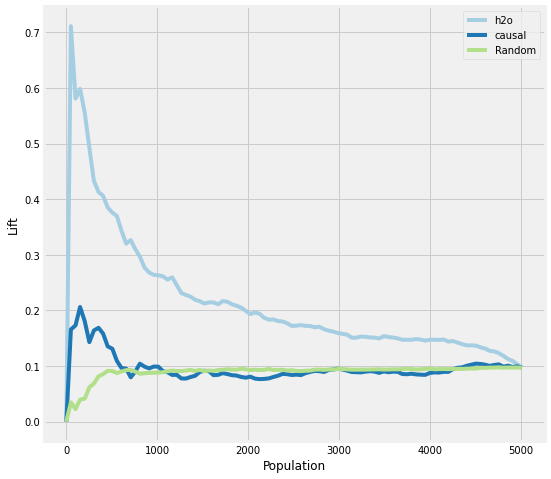

In [14]:
plot_lift(results, outcome_col=response_column, treatment_col=treatment_column)

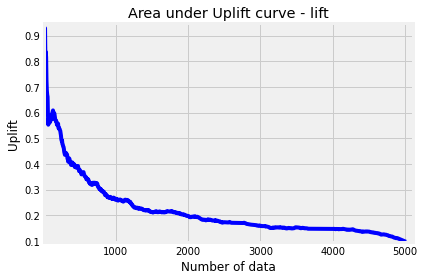

[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 122, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 502, 507, 512, 517, 522, 529, 532, 537, 542, 547, 552, 558, 562, 567, 572, 577, 582, 587, 592, 597, 602, 607, 612, 617, 622, 627, 632, 637, 642, 647, 652, 657, 662, 667, 672, 677, 682, 687, 692, 697, 702, 707, 712, 717, 722, 727, 732, 737, 742, 747, 752, 757, 762, 767, 772, 777, 782, 787, 792, 797, 802, 807, 812, 817, 822, 827, 832, 837, 842, 847, 852, 857, 862, 867, 872, 877, 882, 887, 892, 897, 902, 907, 912, 917, 922, 927, 932, 937, 942, 947, 952, 957, 962, 967, 972, 977, 982, 987, 992, 997, 1003, 1008, 1013, 1018, 

In [15]:
perf_h2o.plot_auuc(metric="lift")

n, uplift = perf_h2o.plot_auuc(metric="lift", plot=False)
print(n)
print(uplift)

## Gain

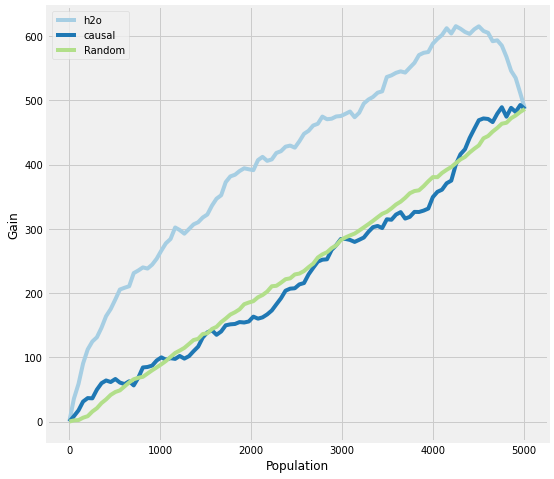

In [16]:
plot_gain(results, outcome_col=response_column, treatment_col=treatment_column)

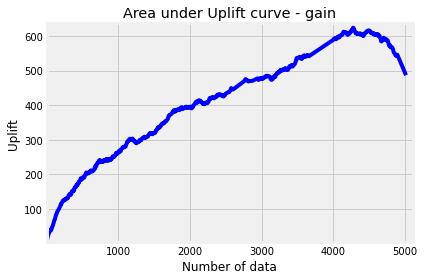

[6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 122, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 502, 507, 512, 517, 522, 529, 532, 537, 542, 547, 552, 558, 562, 567, 572, 577, 582, 587, 592, 597, 602, 607, 612, 617, 622, 627, 632, 637, 642, 647, 652, 657, 662, 667, 672, 677, 682, 687, 692, 697, 702, 707, 712, 717, 722, 727, 732, 737, 742, 747, 752, 757, 762, 767, 772, 777, 782, 787, 792, 797, 802, 807, 812, 817, 822, 827, 832, 837, 842, 847, 852, 857, 862, 867, 872, 877, 882, 887, 892, 897, 902, 907, 912, 917, 922, 927, 932, 937, 942, 947, 952, 957, 962, 967, 972, 977, 982, 987, 992, 997, 1003, 1008, 1013, 1018, 

In [17]:
perf_h2o.plot_auuc(metric="gain")

n, uplift = perf_h2o.plot_auuc(metric="gain", plot=False)
print(n)
print(uplift)